# Latent Masking via Diffusion Models

Latent masking adversarial attacks are a type of semantic attack that operates in the latent space of generative models, such as diffusion models or autoencoders, rather than directly manipulating pixel values. Instead of applying small perturbations to input images, these attacks strategically modify or "mask" components of the latent representation to steer the generated output toward a specific, misleading target while preserving high perceptual similarity. This technique allows adversarial examples to be more interpretable and transferable across models, as the modifications align with the semantic structure learned by the model. Latent masking is particularly effective against generative models, where controlling high-level features can result in subtle yet powerful adversarial effects.


Initially, we planned to conduct experiments on two datasets: CelebA-HQ and AFHQ, and to fine-tune ResNet-18 models on both for 30 epochs. However, we later discovered that no appropriate pre-trained diffusion model was available for AFHQ dataset. Consequently, we had to train a diffusion model from scratch for the AFHQ dataset. Due to GPU resource limitations, this training was computationally expensive and time-consuming. Therefore, we decided to focus our experiments exclusively on the CelebA-HQ dataset to ensure timely and efficient results. For CelebA-HQ we achieved training accuracy of 99.95% and for tesing - 90.288% for ResNet18.


[CelebA-HQ Dataset](https://drive.google.com/file/d/1UvF4UFPMlni8GxCcpQHTaws9YcdkL9Ir/view?usp=sharing)

[Finetuned ResNet18 on CelebA-HQ](https://drive.google.com/file/d/1yUNmBUFPqytF_-EYAEJg9NTNkSllqjJL/view?usp=sharing)

[Pretrained DiffusionClip on CelebA-HQ](https://huggingface.co/gwang-kim/DiffusionCLIP-CelebA_HQ/tree/main)

For the generation of adversarial examples, we utilized the implementation provided in the following GitHub repository: [Github Link](https://github.com/steven202/semantic_adv_via_dm). This repository served as the base framework for our experiments, however the original code was written in Python 3.8.12 and included dependencies that were incompatible with many current library versions. To ensure smooth execution of our experiments, we modified the original codebase, resolving version conflicts and adapting the implementation to integrate the latent masking attack strategy within our experimental setup.

This Jupyter Notebook (.ipynb) serves as the main interface for running the adversarial attacks and displaying the results. To keep the repository lightweight and user-friendly, all modified source code, pre-trained and fine-tuned models, and datasets are bundled into a ZIP archive hosted on [Google Drive](https://drive.google.com/file/d/10GT35XAhfK470MC-Nl40GnZ8EKvGHaNL/view?usp=sharing). Users can download this archive as needed. This approach simplifies usage by allowing users to run the experiments directly from the notebook without handling numerous separate files.

We conducted a series of experiments involving various combinations of adversarial attack strategies. The generated adversarial examples correspond to five runs for each of the following methods: Grad-CAM Black-box with Mixed Mask, Grad-CAM White-box with Victim Mask, and Grad-CAM White-box with Mixed Mask. Additionally, we generated ten adversarial examples for each of the two methods: Full SmoothGrad Black-box with Mixed Mask and Full SmoothGrad White-box with Victim Mask. Due to the computational demands of these attacks—each image generation requiring approximately 4 to 6 minutes on a GPU—the total number of generated images remains limited. The complete set of experimental outputs can be accessed via the following [Google Drive link](https://drive.google.com/drive/folders/1atIyXcr4qor_5cJSaxZ9OAUOb7OWiQ1x?usp=sharing).



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# download the whole directory which we will need
!gdown --id 10GT35XAhfK470MC-Nl40GnZ8EKvGHaNL

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=10GT35XAhfK470MC-Nl40GnZ8EKvGHaNL
From (redirected): https://drive.google.com/uc?id=10GT35XAhfK470MC-Nl40GnZ8EKvGHaNL&confirm=t&uuid=7ded59fa-9509-4369-adfa-af92ebaef223
To: /content/DS235-gai-project.zip
100% 3.59G/3.59G [01:28<00:00, 40.7MB/s]


In [ ]:
# unzip it

import zipfile
import os

zip_path = 'DS235-gai-project.zip'
extract_path = 'gai-project'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
import sys
sys.path.append('/content/gai-project/gai-project/semantic_adv_via_dm')
os.chdir('/content/gai-project/gai-project/semantic_adv_via_dm')
!ls #just to check everything is right

afhq_main.ipynb
afhq_resnet18.pth
afhq.zip
CelebA_HQ_facial_identity_dataset
CelebA_HQ_facial_identity_dataset.zip
commands
configs
datasets
diffusionclip_afhq_train.py
diffusionclip.py
environment.yml
facial_identity_classification_transfer_learning_with_ResNet18_resolution.pth
identity_indices.ipynb
improved_precision_recall.py
losses
main_1.ipynb
main_afhq_train.py
main.ipynb
main_naxkin.ipynb
main.py
models
pick_indices_afhq.py
pick_indices_gender.py
pick_indices_identity.py
pretrained
README.md
requirements.txt
saliency
saved_indices
saved_indices.zip
test_asr_pgd.py
test_asr.py
train_classifier_afhq.py
train_classifier_extractor.py
train_classifier_identity_pgd_l2.py
train_classifier_identity_pgd_linf.py
train_classifier.py
utils


In [ ]:
# create __init__.py if its not already there
!touch /content/gai-project/gai-project/semantic_adv_via_dm/datasets/__init__.py


In [ ]:
# Installing necessary libraries

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install lmdb
!pip install grad-cam
!pip install torchattacks
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 5.1 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-l98wzi7f
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-l98wzi7f
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!mkdir -p /root/.cache/torch/hub/checkpoints
!cp /content/gai-project/gai-project/semantic_adv_via_dm/pretrained/celeba_hq.ckpt /root/.cache/torch/hub/checkpoints/


In [ ]:
!mkdir -p /content/gai-project/gai-project/semantic_adv_via_dm/classifier_ckpts
!cp /content/gai-project/gai-project/semantic_adv_via_dm/facial_identity_classification_transfer_learning_with_ResNet18_resolution.pth /content/gai-project/gai-project/semantic_adv_via_dm/classifier_ckpts/resnet_pgd_linf.pt


In [ ]:
import os
print(os.getcwd())


/content/gai-project/gai-project/semantic_adv_via_dm


## Attack Generation

This attack method leverages latent masking to generate semantic adversarial examples by manipulating high-level features within the model’s latent space. The process is controlled through several configurable parameters that allow customization of the dataset, attack settings, and explainability techniques. By modifying the following parameters, you can control the specific configuration of the attack, resulting in different combinations and thus distinct approaches:

* `--black` Indicates whether the attack is black-box (1) or white-box (0).

* `--mask` Selects the explainability method used to generate the mask for the attack. Options include 2 for GradCAM, 3 for FullGrad, 4 for SimpleFullGrad, and 5 for SmoothFullGrad.

* `--diff` Determines the basis for generating the attack, with 1 using the source image, 2 the target image, and 3 a combination of both.


The provided code enables the generation of adversarial images using the specified attack methods. Please note that each image generation process requires significant computational resources and takes approximately 5 minutes on average. Consequently, generating a large number of adversarial images may result in substantial overall processing time. Users are advised to plan accordingly when running extensive experiments.

## Examples
White-box attack configuration utilizing GradCAM-based interpretation maps, with the adversarial mask generated solely from the victim (source) image.

In [ ]:
!python main.py --attack                 \
            --config celeba.yml         \
            --exp experimental_log_path \
            --n_test_img 4              \
            --t_0 500                   \
            --n_inv_step 40             \
            --n_test_step 40            \
            --n_precomp_img 500 --mask 2 --diff 1 --tune 3 --black 0

Traceback (most recent call last):
  File "/content/gai-project/gai-project/semantic_adv_via_dm/main.py", line 11, in <module>
    from diffusionclip import DiffusionCLIP
  File "/content/gai-project/gai-project/semantic_adv_via_dm/diffusionclip.py", line 6, in <module>
    from torchvision.models.inception import inception_v3
  File "/usr/local/lib/python3.11/dist-packages/torchvision/__init__.py", line 10, in <module>
    from torchvision import _meta_registrations, datasets, io, models, ops, transforms, utils  # usort:skip
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torchvision/models/__init__.py", line 2, in <module>
    from .convnext import *
  File "/usr/local/lib/python3.11/dist-packages/torchvision/models/convnext.py", line 8, in <module>
    from ..ops.misc import Conv2dNormActivation, Permute
  File "/usr/local/lib/python3.11/dist-packages/torchvision/ops/__init__.py", line 23, 

White-box attack configuration utilizing GradCAM-based interpretation maps, with the adversarial mask generated from both the victim and the target images.

In [ ]:
!python main.py --attack                 \
            --config celeba.yml         \
            --exp experimental_log_path \
            --n_test_img 4              \
            --t_0 500                   \
            --n_inv_step 40             \
            --n_test_step 40            \
            --n_precomp_img 500 --mask 2 --diff 3 --tune 3 --black 0

INFO - main.py - 2025-05-16 11:28:01,685 - Using device: cuda
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
INFO - main.py - 2025-05-16 11:28:01,685 - Exp instance id = 4717
INFO - main.py - 2025-05-16 11:28:01,685 - Exp comment = 
INFO - main.py - 2025-05-16 11:28:01,685 - Config =
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
experimental_log_path_box_white_tune_3_mask2_diff3_identity
None is loaded.
None is loaded.
face identity classification
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weight

Black-box attack configuration utilizing GradCAM-based interpretation maps, with the adversarial mask generated from both the victim and the target images.

In [ ]:
!python main.py --attack                 \
            --config celeba.yml         \
            --exp experimental_log_path \
            --n_test_img 4              \
            --t_0 500                   \
            --n_inv_step 40             \
            --n_test_step 40            \
            --n_precomp_img 500 --mask 2 --diff 3 --tune 3 --black 1

INFO - main.py - 2025-05-16 12:06:06,782 - Using device: cuda
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
INFO - main.py - 2025-05-16 12:06:06,782 - Exp instance id = 14332
INFO - main.py - 2025-05-16 12:06:06,782 - Exp comment = 
INFO - main.py - 2025-05-16 12:06:06,782 - Config =
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
experimental_log_path_box_black_tune_3_mask2_diff3_identity
None is loaded.
None is loaded.
face identity classification
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weigh

Black-box attack configuration utilizing GradCAM-based interpretation maps, with the adversarial mask generated solely from the victim (source) image.

In [ ]:
!python main.py --attack                 \
            --config celeba.yml         \
            --exp experimental_log_path \
            --n_test_img 4              \
            --t_0 500                  \
            --n_inv_step 40             \
            --n_test_step 40            \
            --n_precomp_img 500 --mask 2 --diff 1 --tune 3 --black 1

INFO - main.py - 2025-05-16 09:47:09,919 - Using device: cuda
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
INFO - main.py - 2025-05-16 09:47:09,919 - Exp instance id = 25555
INFO - main.py - 2025-05-16 09:47:09,919 - Exp comment = 
INFO - main.py - 2025-05-16 09:47:09,919 - Config =
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
experimental_log_path_box_black_tune_3_mask2_diff1_identity
None is loaded.
None is loaded.
face identity classification
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weigh

White-box attack configuration utilizing Full SmoothGrad-based interpretation maps, with the adversarial mask generated solely from the victim (source) image.

In [ ]:
!python main.py --attack                 \
            --config celeba.yml         \
            --exp experimental_log_path \
            --n_test_img 4              \
            --t_0 500                  \
            --n_inv_step 40             \
            --n_test_step 40            \
            --n_precomp_img 500 --mask 5 --diff 1 --tune 3 --black 0

INFO - main.py - 2025-05-16 13:08:39,785 - Using device: cuda
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
INFO - main.py - 2025-05-16 13:08:39,785 - Exp instance id = 3501
INFO - main.py - 2025-05-16 13:08:39,785 - Exp comment = 
INFO - main.py - 2025-05-16 13:08:39,785 - Config =
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
experimental_log_path_box_white_tune_3_mask5_diff1_identity
None is loaded.
None is loaded.
face identity classification
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weight

Black-box attack configuration utilizing Full SmoothGrad-based interpretation maps, with the adversarial mask generated from both the victim and the target images.



In [ ]:
!python main.py --attack                 \
            --config celeba.yml         \
            --exp experimental_log_path \
            --n_test_img 4              \
            --t_0 500                  \
            --n_inv_step 40             \
            --n_test_step 40            \
            --n_precomp_img 500 --mask 5 --diff 3 --tune 3 --black 1

INFO - main.py - 2025-05-16 13:54:03,920 - Using device: cuda
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
INFO - main.py - 2025-05-16 13:54:03,920 - Exp instance id = 14817
INFO - main.py - 2025-05-16 13:54:03,920 - Exp comment = 
INFO - main.py - 2025-05-16 13:54:03,920 - Config =
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
experimental_log_path_box_black_tune_3_mask5_diff3_identity
None is loaded.
None is loaded.
face identity classification
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weigh

## Visualizations

In [5]:
!pip install -q gdown
import gdown

# File ID and output filename
file_id = '1CeyoSECFwaMspbjX0aaOZBGKIoI6yZt7'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output='adversarial_experiments.zip', quiet=False)

import zipfile

with zipfile.ZipFile('adversarial_experiments.zip', 'r') as zip_ref:
    zip_ref.extractall('experiments')  # Or any directory you prefer


Downloading...
From (original): https://drive.google.com/uc?id=1CeyoSECFwaMspbjX0aaOZBGKIoI6yZt7
From (redirected): https://drive.google.com/uc?id=1CeyoSECFwaMspbjX0aaOZBGKIoI6yZt7&confirm=t&uuid=09251602-57ff-49b0-b6eb-dad796eed2a6
To: /content/adversarial_experiments.zip
100%|██████████| 108M/108M [00:00<00:00, 129MB/s]


### Black Box, Full Smooth Grad Mixed Masked adversarial images

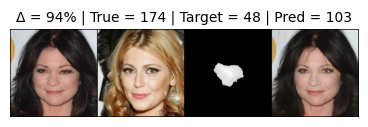

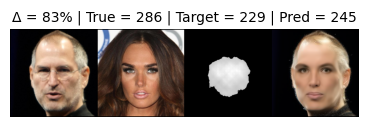

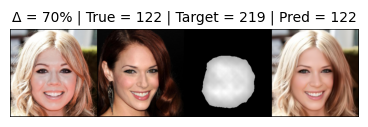

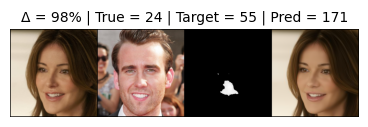

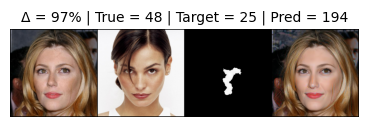

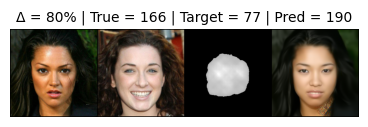

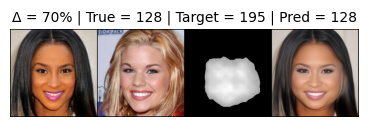

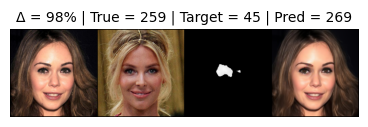

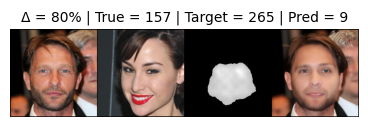

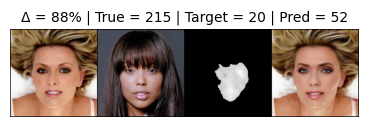

In [22]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def parse_metadata_from_filename(filename):
    """Extract delta, true label, target label, and prediction from the image filename."""
    base = os.path.basename(filename)
    parts = base.split('_')

    delta = parts[2]  # e.g., 98 in train_3_98...
    true_label = parts[5]  # lbl1_24
    target_label = parts[7]  # lbl2_55
    pred_label = parts[9]  # pred3_171

    return {
        'delta': delta,
        'true_label': true_label,
        'target_label': target_label,
        'pred_label': pred_label
    }

# Directory containing images
image_dir = '/content/experiments/AdversarialResults/experimental_log_path_box_black_tune_3_mask5_diff3_identity/image_samples/'
all_images = sorted(glob.glob(os.path.join(image_dir, '*.png')))

# Filter images that contain 'true' or 'false' in their filenames
filtered_images = [img for img in all_images if 'true' in os.path.basename(img).lower() or 'false' in os.path.basename(img).lower()]

# Visualize
for path in filtered_images[:10]:  # Show up to 10 images, adjust as needed
    metadata = parse_metadata_from_filename(path)
    img = mpimg.imread(path)

    plt.figure(figsize=(4.5, 4.5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(
        f"Δ = {metadata['delta']}% | True = {metadata['true_label']} | "
        f"Target = {metadata['target_label']} | Pred = {metadata['pred_label']}",
        fontsize=10
    )
    plt.show()


### Black Box GradCAM Mixed Mask Adversarial Images

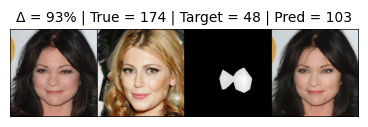

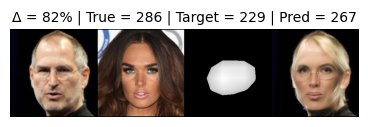

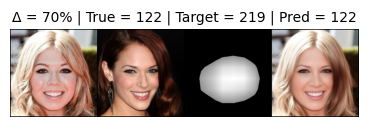

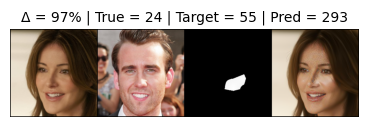

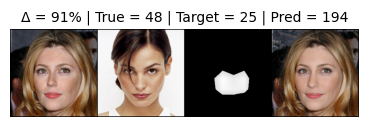

In [14]:
image_dir = "/content/unzipped_output/AdversarialResults/experimental_log_path_box_black_tune_3_mask2_diff3_identity/image_samples"
all_images1 = sorted(glob.glob(os.path.join(image_dir, '*.png')))

# Filter images that contain 'true' or 'false' in their filenames
filtered_images1 = [img for img in all_images1 if 'true' in os.path.basename(img).lower() or 'false' in os.path.basename(img).lower()]

# Visualize
for path in filtered_images1[:10]:  # Show up to 10 images, adjust as needed
    metadata = parse_metadata_from_filename(path)
    img = mpimg.imread(path)

    plt.figure(figsize=(4.5, 4.5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(
        f"Δ = {metadata['delta']}% | True = {metadata['true_label']} | "
        f"Target = {metadata['target_label']} | Pred = {metadata['pred_label']}",
        fontsize=10
    )
    plt.show()

### White Box,  Grad CAM Victim Masked adversarial images

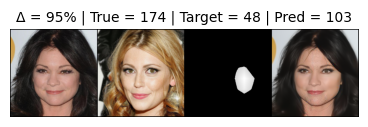

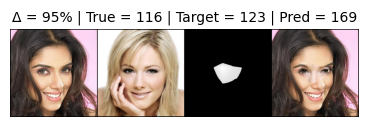

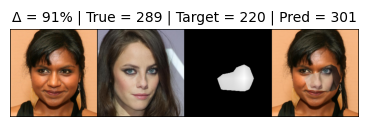

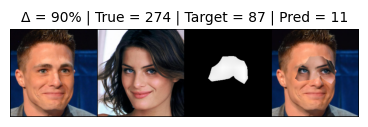

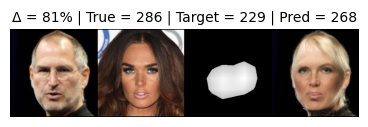

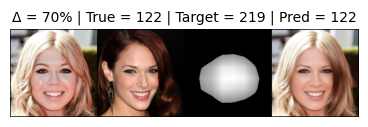

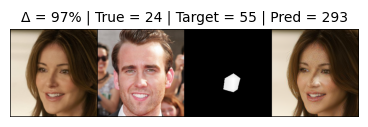

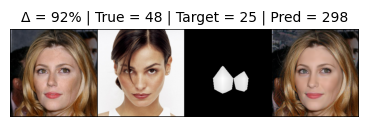

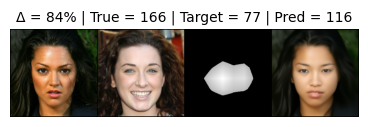

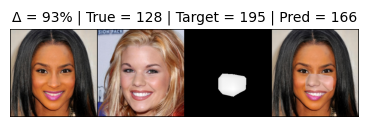

In [16]:
image_dir = "/content/unzipped_output/AdversarialResults/experimental_log_path_box_white_tune_3_mask2_diff1_identity/image_samples"
all_images2 = sorted(glob.glob(os.path.join(image_dir, '*.png')))

# Filter images that contain 'true' or 'false' in their filenames
filtered_images2 = [img for img in all_images2 if 'true' in os.path.basename(img).lower() or 'false' in os.path.basename(img).lower()]

# Visualize
for path in filtered_images2[:10]:  # Show up to 10 images, adjust as needed
    metadata = parse_metadata_from_filename(path)
    img = mpimg.imread(path)

    plt.figure(figsize=(4.5, 4.5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(
        f"Δ = {metadata['delta']}% | True = {metadata['true_label']} | "
        f"Target = {metadata['target_label']} | Pred = {metadata['pred_label']}",
        fontsize=10
    )
    plt.show()

### White Box, GradCAM Mixed Masked adversarial images

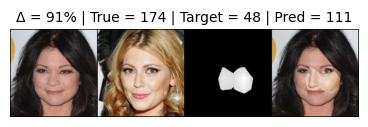

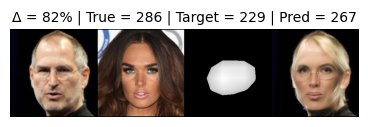

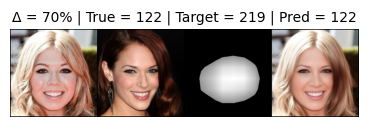

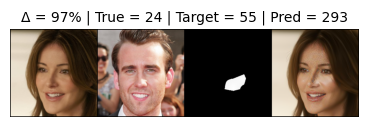

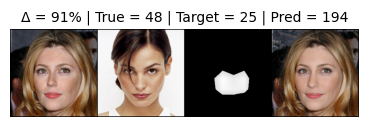

In [18]:
image_dir = "/content/unzipped_output/AdversarialResults/experimental_log_path_box_white_tune_3_mask2_diff3_identity/image_samples"
all_images3 = sorted(glob.glob(os.path.join(image_dir, '*.png')))

# Filter images that contain 'true' or 'false' in their filenames
filtered_images3 = [img for img in all_images3 if 'true' in os.path.basename(img).lower() or 'false' in os.path.basename(img).lower()]

# Visualize
for path in filtered_images2[:10]:  # Show up to 10 images, adjust as needed
    metadata = parse_metadata_from_filename(path)
    img = mpimg.imread(path)

    plt.figure(figsize=(4.5, 4.5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(
        f"Δ = {metadata['delta']}% | True = {metadata['true_label']} | "
        f"Target = {metadata['target_label']} | Pred = {metadata['pred_label']}",
        fontsize=10
    )
    plt.show()

### White Box, Full Smooth Grad Victim Masked adversarial images

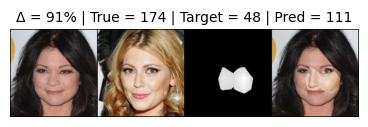

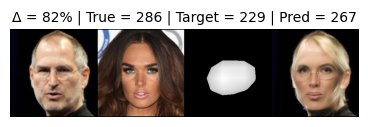

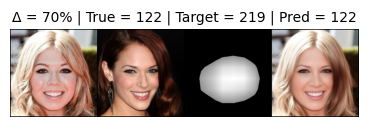

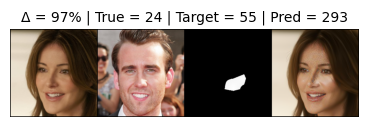

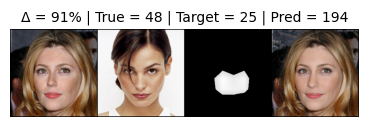

In [20]:
image_dir = "/content/unzipped_output/AdversarialResults/experimental_log_path_box_white_tune_3_mask5_diff1_identity/image_samples"
all_images4 = sorted(glob.glob(os.path.join(image_dir, '*.png')))

# Filter images that contain 'true' or 'false' in their filenames
filtered_images4 = [img for img in all_images4 if 'true' in os.path.basename(img).lower() or 'false' in os.path.basename(img).lower()]

# Visualize
for path in filtered_images2[:10]:  # Show up to 10 images, adjust as needed
    metadata = parse_metadata_from_filename(path)
    img = mpimg.imread(path)

    plt.figure(figsize=(4.5, 4.5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(
        f"Δ = {metadata['delta']}% | True = {metadata['true_label']} | "
        f"Target = {metadata['target_label']} | Pred = {metadata['pred_label']}",
        fontsize=10
    )
    plt.show()